Alex Bombrun

created 11/02/2019

updated 19/03/2019

An illustration of the close pair issue in Gaia DR2 using the 2018 GaiaLab code.

In [2]:
import sys
# append to path the folder that contains the analytic scanner
sys.path.append('../../GaiaLab/scan/analytic_scanner')

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

import quaternion
from agis import Agis
from agis import Calc_source
import agis_functions as af
import helpers as helpers
import analytic_plots as aplots

import numpy as np
import astropy.units as units
import matplotlib.pyplot as plt

# Initialisation
The mission duration is 2 years. 

Note the current implementation of the scanning law is not the operational Gaia nominal scanning law but an older one.

In [3]:
t_init = 0 
t_end =  365*2
my_dt = 1/24 # knot interval of the spline used as the true scanning law [days]
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
scanner = Scanner()

# Data model and solver

## source

We have quite a number of possibility to represent a source, as a simple array 
$$\alpha,\delta,\varpi,\mu_{\alpha*},\mu_{delta}$$, 
as a *Source* or as a *Calc_source*. 

In [4]:
class calc_src :
    """the data structure that is used for a calculated source"""
    def __init__(self,alpha,delta,varpi,muAlphaStar,muDelta):
        self.s_params = [alpha,delta,varpi,muAlphaStar,muDelta]
        self.mu_radial = 0.0

the agis.py code is not as simple as promised, basic functionalities such as source solver are not obvious, below is a few guidelines and explorations.

## solver
As mentioned previously we propose here our one solver. Some functionalities might, should, be included in GaiaLab.

In [35]:
def compute_du_ds(p,q,r,q_l,t_l):
    """
    computes and return the derivative of the source direction with respect to the source parameters
    
    params p,q,r : the vectors defining the frame associated to a source position at reference epoch
    params q_l,t_l : the attitude at time t_l
    returns : du_ds_SRS as a 3x5 array
    """
    # Equation 73
    r.shape = (3, 1)  # reshapes r
    b_G = gaia.ephemeris_bcrs(t_l)
    tau = t_l - const.t_ep  # + np.dot(r, b_G) / const.c
    # Compute derivatives
    du_ds_CoMRS = [p, q, af.compute_du_dparallax(r, b_G), p*tau, q*tau]
    # Equation 72
    # should be changed to a pythonic map
    du_ds_SRS = []
    for derivative in du_ds_CoMRS:
        du_ds_SRS.append(ft.lmn_to_xyz(q_l, derivative))
    return np.array(du_ds_SRS)

def computeScanAngle(p0,q0,z):
    """
    Compute the scan direction angle theta = atan2(q0'z, -p0'z) 
    param p0 : local East (increasing alpha) 
    param q0 : local North (increasing delta if |delta_0|<90) 
    param z : unit vector z obtained from the attitude quaternion at the time of transit
    See equation (1) in LL-061 and equation (13)
    """
    return np.arctan2(q0@z,-p0@z)

def zero_offset(p0,q0,q):
    return 0

def close_pair_model(thetaScan,theta=0.1,r=100,dG=0.1,modFactor=1.15,decayModFactor = 150):
    """
    param theta,r : close pair position in polar coordinate (radian from north direction, mas)
    param dG : close pair magnitude decay 
    param modFactor,decayModFactor : parameter of the LSF close pair model perturbation
    return : the offset in mas
    """
    projectedSep = np.cos(theta-thetaScan)*r
    offset_mas = np.exp(-dG/modFactor) * projectedSep * np.exp( -np.abs(projectedSep)/decayModFactor )
    return offset_mas

def eta_close_pair(p0,q0,q,
                   theta=0.1,r=100,dG=0.1,modFactor=1.15,decayModFactor = 150):
    """close pair model of an eta offset due to a secondary source at (theta,r)
    param p0 : local East (increasing alpha) 
    param q0 : local North (increasing delta if |delta_0|<90) 
    param q : attitude quaternion
    param theta,r : close pair position in polar coordinate (radian from north direction, mas)
    param dG : close pair magnitude decay 
    param modFactor,decayModFactor : parameter of the LSF close pair model perturbation
    """
    z = ft.xyz_to_lmn(q, np.array([0,0,1]))
    thetaScan = computeScanAngle(p0,q0,z)
    return close_pair_model(thetaScan,theta,r,dG,modFactor,decayModFactor)*units.mas.to(units.rad)
    

def compute_design_equation(true_source,calc_source,observation_times,eta_offset):
    """
    param true_source : the parameters of the true source
    param calc_source : the parameters of the estimated source
    param observation_times : scanner observation times
    returns : dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA(phi_obs, zeta_obs,phi_calc, zeta_calc)
    """
    alpha0 = calc_source.s_params[0]
    delta0 = calc_source.s_params[1]    
    p0, q0, r0 = ft.compute_pqr(alpha0, delta0)
    n_obs = len(observation_times)
    O_AL = np.zeros(n_obs) #AL offset 
    R_AL = np.zeros(n_obs) #AL residual
    R_AC = np.zeros(n_obs) #AC residual
    dR_ds_AL = np.zeros((n_obs, 5)) #AL derivatives
    dR_ds_AC = np.zeros((n_obs, 5)) #AC derivatives
    FA = [] # field angle
    for j, t_l in enumerate(observation_times): 
        # one should use the 2 telescopes option for the residuals
        q_l = gaia.func_attitude(t_l)
        phi_obs, zeta_obs = af.observed_field_angles(true_source, q_l, gaia, t_l, True)
        phi_calc, zeta_calc = af.calculated_field_angles(calc_source, q_l, gaia, t_l, True)
        
        FA.append([phi_obs, zeta_obs,phi_calc, zeta_calc])
        
        O_AL[j] = eta_offset(p0,q0,q_l)
        R_AL[j] = (phi_obs-phi_calc) + O_AL[j]
        R_AC[j] = (zeta_obs-zeta_calc)
        
        # but not for the derivatives...
        phi_c, zeta_c = af.calculated_field_angles(calc_source, q_l, gaia, t_l, False)
        m, n, u = af.compute_mnu(phi_c, zeta_c)
        
        du_ds = compute_du_ds(p0,q0,r0,q_l,t_l)
        dR_ds_AL[j, :] = m @ du_ds.transpose() * helpers.sec(zeta_calc)
        dR_ds_AC[j, :] = n @ du_ds.transpose()
    return dR_ds_AL, dR_ds_AC, R_AL, R_AC, np.array(FA), np.array(O_AL)

def solve_AL(true_source,calc_source,observation_times,eta_offset):
    """
    perform one step of the source solver using only along scan observations
    """
    # get the design equation
    dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL = compute_design_equation(true_source,calc_source,observation_times,eta_offset)
    # build the normal equation
    N = dR_ds_AL.transpose() @ dR_ds_AL 
    rhs = dR_ds_AL.transpose() @ R_AL
    # solve the normal equation
    updates = np.linalg.solve(N,rhs)
    # update the calculated source parameters
    # take care of alpha
    calc_source.s_params[0] = calc_source.s_params[0] + updates[0] * np.cos(calc_source.s_params[1])
    calc_source.s_params[1:] = calc_source.s_params[1:] + updates[1:]
    
import constants as const
def toSource(calculated_Source,name):
    alpha0 = calculated_Source.s_params[0]*units.rad.to(units.deg)
    delta0 = calculated_Source.s_params[1]*units.rad.to(units.deg)
    varpi = calculated_Source.s_params[2]*units.rad.to(units.mas)
    # why do we use muAlpha?
    muAlpha = calculated_Source.s_params[3]*units.rad.to(units.mas) * const.days_per_year / np.cos(delta0)
    muDelta = calculated_Source.s_params[4]*units.rad.to(units.mas) * const.days_per_year
    print([alpha0, delta0, varpi, muAlpha, muDelta])
    return Source(name, alpha0, delta0, varpi, muAlpha, muDelta, 0, func_color=zero_color, mean_color=0 )

def plot_sky_observations(sat, source, obs_times, offset_mas):
    positions = []
    for i, t in enumerate(obs_times):
        # scan position
        half_interval = 1 * 1/24/60/60/1000 # 1ms
        scan_position = []
        for ti in np.linspace(t-half_interval, t+half_interval, num=3):
            my_a,my_d = ft.vector_to_alpha_delta(aplots.get_obs_in_CoMRS(source, sat, ti))
            scan_position.append([my_a-source.alpha,my_d-source.delta])
            #vto = ft.vector_to_alpha_delta(aplots.get_obs_in_CoMRS(source, sat, t + offset_day))
        scan_position = np.array(scan_position)/const.rad_per_mas
        plt.plot(scan_position[:,0], scan_position[:,1], 'r-', alpha=0.3)
        
    offset_position = []
    for i, t in enumerate(obs_times):
        # offset
        offset_day = offset_mas[i]/sat.wz
        my_a,my_d = ft.vector_to_alpha_delta(aplots.get_obs_in_CoMRS(source, sat, t+offset_day))
        offset_position.append([my_a-source.alpha,my_d-source.delta])
    offset_position = np.array(offset_position)/const.rad_per_mas
    plt.scatter(offset_position[:,0],offset_position[:,1],c = obs_times,label="observation offset")
    plt.colorbar(label="observation time [day]")
    plt.legend()
    plt.grid()
    plt.xlabel("alpha - alpha0 [mas]")
    plt.ylabel("delta - delta0 [mas]")

# Source scan

Here we choose the source to be like a QSO, i.e. zero parallax and zero proper motion.

In [6]:
zero_color = lambda t: 0
LQSO = Source("LQSO", 180, 50, 0, 0, 0, 0, func_color=zero_color, mean_color=0 )

In [7]:
scanner.scan(gaia, LQSO, t_init, t_end)
scanner.compute_angles_eta_zeta(gaia, LQSO)
scanner_observation_times = scanner.obs_times

### Some explanation about the scanner
Let $u_{source}(t)$ be the source direction and $u_{telescope}(t)$ be the pointing direction of one of the telescope. In the scanner solves the folowing system of equation in t, 
$$ \pi_{xy} u_{source}(t) = \pi_{xy} u_{telescope}(t)$$ $$|\pi_{z} u_{source}| < \epsilon $$
where $\{xyz\}$ defined the satellite reference frame, $z$ being the spin axis and $xy$ the orthogonal plane, i.e. one solves a constraint problem with an equality in the along scan direction.   

In term of along scan and across scan field angles, $(\varphi,\zeta)$,
$$ \varphi(t) = \pm \Gamma_c/2 \,,\, |\zeta(t)| < \epsilon $$
where $\Gamma_c$ is the nominal basic angle between the 2 telescopes and $2 \epsilon$ the size of the field of view across scan.

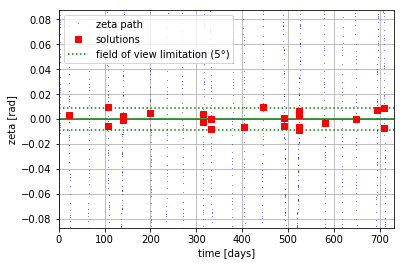

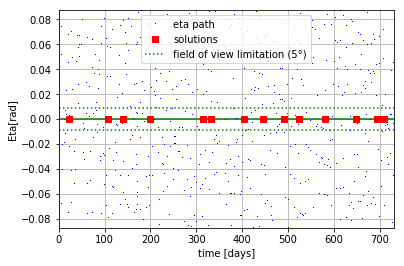

In [8]:
aplots.plot_field_angles(source=LQSO, sat=gaia, obs_times=scanner.obs_times, ti=t_init, tf=t_end, 
                  n=10000, limit=True, double_telescope=True);

Doing a zoom one can see that without the constraint, there is a solution $\eta=0$ at each revolution. The scanner only keeps the observation when the source is visible in the field of view defined by the constraint.

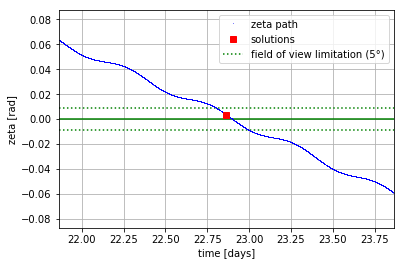

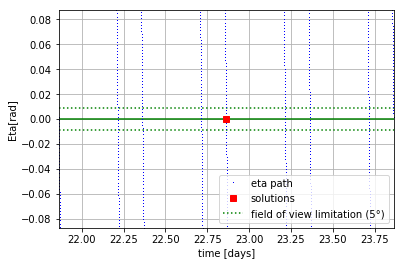

In [9]:
aplots.plot_field_angles(source=LQSO, sat=gaia, obs_times=scanner.obs_times, 
                         ti=scanner.obs_times[0]-1, tf=scanner.obs_times[0]+1, 
                  n=10000, limit=True, double_telescope=True);

## projection of the observations on the sky
Since our source is not moving and has zero parallax the observations are all centered at $\alpha_0,\delta_0$. 
Because of the scanning law there are some preference scanning direction. 

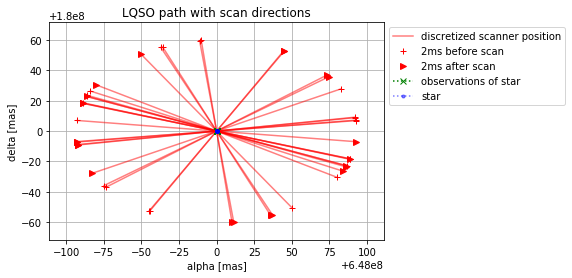

In [10]:
aplots.plot_star_trajectory_with_scans(sat=gaia, source=LQSO, obs_times=scanner.obs_times, 
                                      num_ms_for_snapshot=2);

# Close pair eta offset

The close pair model is derived from the problematic of fitting a bimodal distribution by a single Gaussian.

In [11]:
from scipy.optimize import leastsq,curve_fit
from scipy import stats

Text(0.5,1,'two Gaussian')

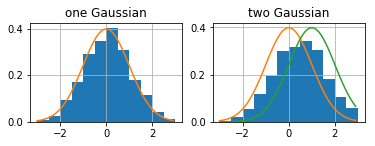

In [12]:
plt.subplot(221)
n1 = np.random.normal(0,1,1000)
h1 = plt.hist(list(n1),bins=12,normed=True,range=(-3,3))
x = np.arange(-3,3,0.1)
y = stats.norm.pdf(x,0,1)
plt.plot(x,y)
plt.grid()
plt.title("one Gaussian")

plt.subplot(222)
n1 = np.random.normal(0,1,1000)
n2 = np.random.normal(1,1,1000)
h2 = plt.hist(list(n1)+list(n2),bins=12,normed=True,range=(-3,3))
x = np.arange(-3,3,0.1)
y0 = stats.norm.pdf(x,0,1)
y1 = stats.norm.pdf(x,1,1)
plt.plot(x,y0)
plt.plot(x,y1)
plt.grid()
plt.title("two Gaussian")

[0.499 0.739]


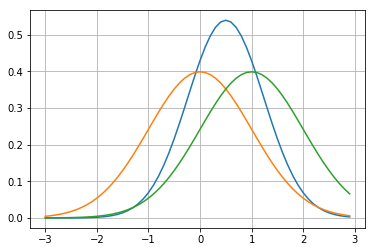

In [13]:
x0 = np.arange(-3,3,1)
y0 = stats.norm.pdf(x0,0,1) + stats.norm.pdf(x0,1,1)
f0 = lambda x: stats.norm.pdf(x0,x[0],x[1])
optimize_median = lambda x: f0(x) - y0
a0, b0 = leastsq(optimize_median, [0.1, 0.9])[0]
print(np.array([a0,b0]).round(3))
x = np.arange(-3,3,0.1)
plt.plot(x,stats.norm.pdf(x,a0,b0))
plt.plot(x,stats.norm.pdf(x,0,1))
plt.plot(x,stats.norm.pdf(x,1,1))
plt.grid()

The close pair model is the model of the along scan observation bias due to the presence of a second source in the viciny of the primary source. 

The close pair model AL offset depends at least on:
* the angular distance of the second source
* the angle between the scanning direction and the direction defined by the second source
* the difference in magnitude between the two sources

Text(0,0.5,'observation offset [mas]')

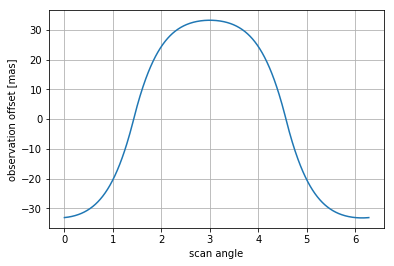

In [15]:
etaScan = np.arange(0,2*np.pi,0.01)
plt.plot(etaScan,close_pair_model(etaScan,theta=3,r=100,dG=0.5))
plt.xlabel("scan angle")
plt.grid()
plt.ylabel("observation offset [mas]")

# Calculated source

In [16]:
def noise_calc_sources(s,noise = 1e-5):
    """
    add noise to source parameters
    """
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/10
    s.s_params[3] += s.s_params[3]*0.1
    s.s_params[4] += s.s_params[4]*0.1

in order not to start the solver with the true value we add some offset to the calculated source

In [17]:
calc_s =  Calc_source(obs_times=scanner_observation_times, source=LQSO, mean_color=LQSO.mean_color)
noise_calc_sources(calc_s)
calc_s.s_params-LQSO.get_parameters()[:5]

array([1.e-05, 1.e-05, 0.e+00, 0.e+00, 0.e+00])

# Solution without observation bias

The field angles values computed in *compute_design_equation* can be used to visualised the source position in the sky as seen in the SRS reference frame associated to the satellite.

In [18]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL = compute_design_equation(LQSO,calc_s,scanner_observation_times,zero_offset)  

From the design equation one computes the normal equation.

In [19]:
N = dR_ds_AL.transpose() @ dR_ds_AL

In [20]:
np.sqrt(R_AL@R_AL)*units.rad.to(units.mas)

7232.260623043696

One can check that the solver is converging after 10 iterations of the source update.

In [21]:
for i in range(0,20):
    solve_AL(LQSO,calc_s,scanner_observation_times,zero_offset)
    calc_s.s_params-LQSO.get_parameters()[:5]
LQSO_C = toSource(calc_s,"LQSO_C")

[180.00000001343648, 49.99999999999999, 1.0049273455341204e-08, 1.720464496886592e-08, 3.176819947577539e-08]


In [22]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL  = compute_design_equation(LQSO,calc_s,scanner_observation_times,zero_offset)  

and we check that the residuals are small

In [23]:
np.sqrt(R_AL@R_AL) * units.rad.to(units.mas)

0.1198831288219214

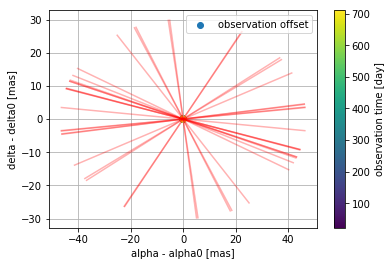

In [24]:
plot_sky_observations(gaia,LQSO,scanner.obs_times,O_AL)

# Solution with close pair observation bias

The field angles values computed in *compute_design_equation* can be used to visualised the source position in the sky as seen in the SRS reference frame associated to the satellite.

In [25]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL = compute_design_equation(LQSO,calc_s,scanner_observation_times,eta_close_pair)  

From the design equation one computes the normal equation.

In [26]:
N = dR_ds_AL.transpose() @ dR_ds_AL

In [27]:
np.sqrt(R_AL@R_AL)*units.rad.to(units.mas)

154.42434502939778

The solver is converging after 10 iterations of the source update. 
The solution has non zero parallaxes and proper motion.

In [28]:
for i in range(0,20):
    solve_AL(LQSO,calc_s,scanner_observation_times,eta_close_pair)
    calc_s.s_params-LQSO.get_parameters()[:5]
LQSO_C = toSource(calc_s,"LQSO_C")

[179.99999893159531, 50.000015478815385, 3.817944113956565, 6.039883819388414, -1.5577404637005996]


In [29]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL  = compute_design_equation(LQSO,calc_s,scanner_observation_times,eta_close_pair)  

and we check thaht the residuals are not as small as without observation systematics.

In [30]:
np.sqrt(R_AL@R_AL) * units.rad.to(units.mas)

18.792312943800827

the computed solution has non zero proper motion and non zero parallax

In [31]:
times = np.arange(t_init,t_end,30)
positions = []
for i, t in enumerate(times):
    alpha, delta, _, _ = LQSO_C.topocentric_angles(gaia, t)
    positions.append([alpha-LQSO_C.alpha,delta-LQSO_C.delta])
positions = np.array(positions)/const.rad_per_mas

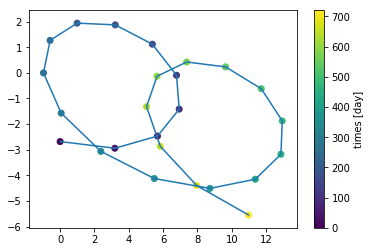

In [32]:
plt.plot(positions[:,0],positions[:,1])
plt.scatter(positions[:,0],positions[:,1],c=times)
plt.colorbar(label="times [day]")

there is a bug in aplots.plot_star_trajectory

In [33]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA, O_AL = compute_design_equation(LQSO,calc_s,scanner_observation_times,eta_close_pair)  

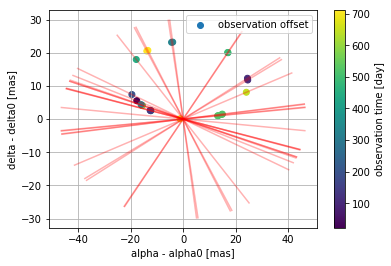

In [34]:
plot_sky_observations(gaia,LQSO,scanner.obs_times,O_AL)